# Comparing inference with fixed and random latents

### Imports

In [1]:
import torch
from diffusers import StableDiffusionPipeline
from matplotlib import pyplot as plt
from PIL import Image

### Util for plotting

In [2]:
def plot_images(images: list[Image]) -> Image:
    width, heigth = images[0].size
    grid = Image.new('RGB', size=(width * len(images), heigth))
    
    for image_idx, image in enumerate(images):
        grid.paste(image, box=(image_idx * width, 0))
    return grid

### Loading model from checkpoint

#### Checkpoint params

```
checkpoint_step=600
lr=1e-4
lora_rank=16
pretrained_model='runwayml/stable-diffusion-v1-5'
train_text_encoder=False
with_prior_preservation=False
```

In [3]:
LOAD_TEXT_ENCODER = False
PRETRAINED_MODEL = 'runwayml/stable-diffusion-v1-5'
CHECKPOINT_PATH = 'output/checkpoint-600/pytorch_lora_weights.safetensors'

model = StableDiffusionPipeline.from_pretrained(
    PRETRAINED_MODEL,
    torch_dtype=torch.half, 
    safety_checker=None,
)

if LOAD_TEXT_ENCODER:
    model.load_lora_weights(CHECKPOINT_PATH)
else:
    model.unet.load_attn_procs(CHECKPOINT_PATH)
model = model.to('cuda')

vae\diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


### Inference with fixed latents and random ones

In [4]:
generator = torch.Generator(device='cuda').manual_seed(42)

latents = torch.randn(
    (1, 4, 64, 64),
    generator=generator,
    device='cuda',
    dtype=torch.half,
)

latents = torch.concatenate((latents, latents))

prompts = [
    'a [V] robot on a cobblestone street',
    'a red [V] robot on a cobblestone street',
]

images_fixed = model(prompt=prompts, latents=latents).images
images = model(prompt=prompts, generator=generator).images

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### Comparison

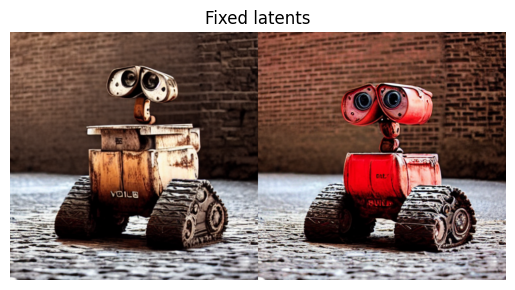

In [5]:
plot_fixed = plot_images(images_fixed)
plt.title('Fixed latents')
plt.axis('off')
plt.imshow(plot_fixed)
plt.show()

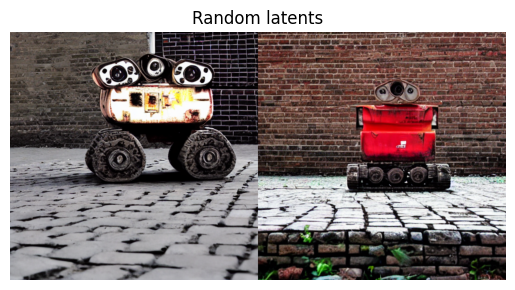

In [6]:
plot = plot_images(images)
plt.title('Random latents')
plt.axis('off')
plt.imshow(plot)
plt.show()